In [5]:
import getpass
import nibabel as nib
from pathlib import Path
import os
import math
import pandas as pd
from tqdm import tqdm
import numpy as np

In [4]:
user = getpass.getuser()

src = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/"
nifti_paths = list(Path(src).glob('Nifti/**/*.nii'))
mask_r_paths = list(Path(src).glob('**/mask_R.nii.gz'))
mask_l_paths = list(Path(src).glob('**/mask_L.nii.gz'))

In [3]:
def save_nib_file(path, nft, nft_affine):
    nft_2_save = nib.Nifti1Image(nft, nft_affine)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nib.save(nft_2_save, path)


def calibrate_color_values(nft_imgs, low_cv = -1250, high_cv = 250):

    calibrated_values = nft_imgs.copy()
    for i, im in enumerate(calibrated_values):
        if any(any(c > high_cv or c < low_cv for c in r) for r in im):
            calibrated_values[i] = [[max(min(c, high_cv), low_cv) for c in r] for r in im]

    return ((calibrated_values - low_cv) / (high_cv-low_cv)) * 255

def get_z_start_stop(mask):
    start_z = 0

    for z in range(mask.shape[2]):
        if mask[:,:,z].any():
            start_z = z
            break

    stop_z = mask.shape[2]

    for z in reversed(range(mask.shape[2])):
        if mask[:,:,z].any():
            stop_z = z
            break

    return start_z, stop_z


def get_x_start_stop(mask):
    start_x = 0

    for x in range(mask.shape[0]):
        if mask[x,:,:].any():
            start_x = x
            break

    stop_x = mask.shape[0]

    for x in reversed(range(mask.shape[0])):
        if mask[x,:,:].any():
            stop_x = x
            break

    return start_x, stop_x

def get_y_start_stop(mask):
    start_y = 0

    for y in range(mask.shape[1]):
        if mask[:,y,:].any():
            start_y = y
            break

    stop_y = mask.shape[1]

    for y in reversed(range(mask.shape[1])):
        if mask[:,y,:].any():
            stop_y = y
            break

    return start_y, stop_y

def adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y, size=(240, 320)):

    w_diff = size[0] - (stop_x - start_x)

    start_x -= math.ceil(w_diff / 2)
    stop_x += math.floor(w_diff / 2)

    if start_x < 0:
        stop_x -= start_x
        start_x = 0
    elif stop_x > nft_data.shape[0]:
        start_x -= stop_x - nft_data.shape[0]
        stop_x = nft_data.shape[0]

    h_diff = size[1] - (stop_y - start_y)

    start_y -= math.ceil(h_diff / 2)
    stop_y += math.floor(h_diff / 2)

    if start_y < 0:
        stop_y -= start_y
        start_y = 0
    elif stop_y > nft_data.shape[1]:
        start_y -= stop_y - nft_data.shape[1]
        stop_y = nft_data.shape[1]

    return start_x, stop_x, start_y, stop_y

def save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, start_z, stop_z):
        
    df = pd.DataFrame({'name': [file_name],
                       'path': [dst_path],
                       'x': [[start_x, stop_x]],
                       'y': [[start_y, stop_y]],
                       'z': [[start_z, stop_z]]})
    
    dst = str(Path(dst_path).parent) + "/df.csv"

    df.to_csv(dst, mode='a',
                header=not os.path.exists(dst))


def generate_chunks(nft, mask_l, mask_r, dst_path, chunk_size=17, spacing=4):

    masks = [mask_l, mask_r]

    nft_data = nft.get_fdata()

    file_name_list = ["L", "R"]

    for i, mask in enumerate(masks):
        
        start_z, stop_z = get_z_start_stop(mask)

        for z in range(start_z + (chunk_size * spacing) * 2, stop_z - chunk_size*spacing, chunk_size * spacing):

            file_name = f"/{file_name_list[i]}_{z}_{z+chunk_size}.nii"

            start_x, stop_x = get_x_start_stop(mask[:,:, z : z + chunk_size])
            start_y, stop_y = get_y_start_stop(mask[:,:, z : z + chunk_size])

            if stop_x - start_x > nft_data.shape[0]//2:
                save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, z, z + chunk_size)

            start_x, stop_x, start_y, stop_y = adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y)

            chunk = calibrate_color_values(nft_data[start_x:stop_x, start_y:stop_y, z : z + chunk_size])

            save_nib_file(dst_path + file_name, chunk, nft.affine)    

In [4]:
def main():

    for nifti_path, mask_r_path, mask_l_path in tqdm(zip(nifti_paths, mask_r_paths, mask_l_paths), total=len(nifti_paths)):

        nft = nib.load(nifti_path)

        mask_r = nib.load(mask_r_path).get_fdata()
        mask_l = nib.load(mask_l_path).get_fdata()

        path = src + 'Preprocessed/' + nifti_path.stem
        
        generate_chunks(nft, mask_l, mask_r, path)

main()

100%|██████████| 57/57 [20:16<00:00, 21.34s/it]


320


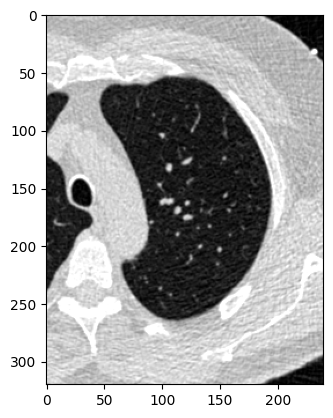

In [12]:
import matplotlib.pyplot as plt
nisan = nib.load(src + 'Preprocessed/1002_bwt/L_419_436.nii').get_fdata()
plt.imshow(np.rot90(nisan[:,:,4]), cmap='gray')
print(nisan.shape[1])